### 3.2 - Long Short-Term Memory (LSTM)

In [1]:
# Load the packages and other tools
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import shap
import numpy as np
import pickle
import tensorflow as tf
from datetime import datetime
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import KFold
from scalecast.Forecaster import Forecaster
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
from keras import optimizers
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\sofia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\sofia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# Reading the model dataset
model1 = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/model/model.xlsx',index_col=0)

* Data preparation:

In [3]:
# Splitting 80% for training and 20% for testing
train = model1[:-323]
len(train)
test = model1[-323:]
len(test)

# Splitting 80% for training and 20% for validation
train = train[:-65]
len(train)
val = train[-65:]
len(test)

print(len(train), 'train sequences')
print(len(test), 'test sequences')
print(len(val), 'validation sequences')

## Regularization

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train['lg_price'].values.reshape(-1,1))

prediction_days = 323

# for training
x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
x_train1, y_train1 = np.array(x_train), np.array(y_train)


# for validation
x_valid, x_train, y_valid, y_train = train_test_split(x_train1,y_train1, train_size=0.8)

1227 train sequences
323 test sequences
65 validation sequences


* Build the model

In [4]:
lstm = Sequential()

lstm.add(LSTM(units =128, activation='relu', return_sequences=True, input_shape = (x_train1.shape[1],1)))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units =128, activation='relu', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units =128, activation='relu', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1)) # Prediction of the next value

lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.summary()

history = lstm.fit(x_train1, y_train1, epochs = 25, batch_size=32, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 323, 128)          66560     
                                                                 
 dropout (Dropout)           (None, 323, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 323, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 323, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [15]:
#lstm.save('lstm_model')

INFO:tensorflow:Assets written to: lstm_model\assets


In [16]:
from keras.models import load_model
lstm = load_model('lstm_model')

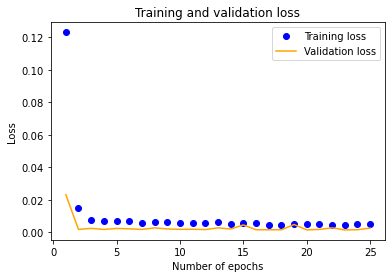

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs= range(1,26)

TL=plt.plot(epochs, loss, 'bo', label='Training loss')
VL=plt.plot(epochs, val_loss, 'b', label='Validation loss',color='orange')
plt.title('Training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/trainVSvalid.jpeg')
plt.show()

*The plot shows that the training operation becomes stable after the second epoch time.*

* Prediction

In [11]:
actual_price = test['lg_price'].values
total_price = pd.concat((train['lg_price'], test['lg_price']),axis=0)

model_inputs = total_price[len(total_price)-len(test)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)


# Make Predictions on Test Data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test1 = np.array(x_test)
x_test2 = np.reshape(x_test1, (x_test1.shape[0], x_test1.shape[1], 1))

# Predicting the values for lg_price
pred = lstm.predict(x_test2)
pred = scaler.inverse_transform(pred)
print(pred[:5]) # Printing lg_price for the next 5 day to check if the values make sense

[[8.939522 ]
 [8.951289 ]
 [8.961153 ]
 [8.9692135]
 [8.975661 ]]


* Evaluation

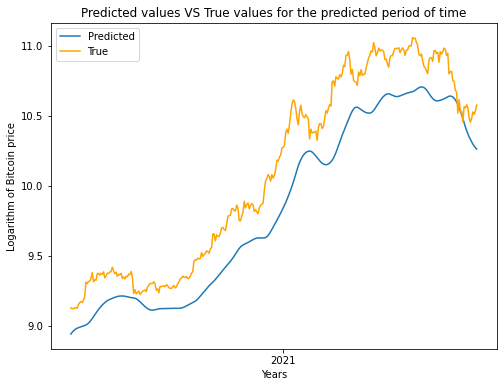

In [19]:
# Plotting the Predicted Bitcin price VS True Bitcoin price for the predicted period of time
original_test=model1.iloc[-323:,0]
date = original_test.index
fig, ax = plt.subplots(figsize=(8, 6))
year_locator = mdates.YearLocator()
ax.xaxis.set_major_locator(year_locator) # Locator for major axis only.
plt.plot(date, pred)
plt.plot(date, original_test,color='orange')
plt.title('Predicted values VS True values for the predicted period of time')
plt.xlabel('Years')
plt.ylabel('Logarithm of Bitcoin price')
plt.legend(['Predicted', 'True'])

# Setting the background color of the plot to white
ax.set_facecolor("white")
ax.spines['left'].set_color('black') 
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('black')

#plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/originalVSpred.jpeg')
plt.show()

*Therefore, in this case, LSTM leads to slightly undervalued predictions most of the time.*

In [13]:
from sklearn.metrics import mean_squared_error

# 1. MSE - Mean Squared Error
MSE = mean_squared_error(actual_price,pred)
print("Mean Square Error: ", MSE)

# 2. RMSE - Root Mean Square Error
RMSE = math.sqrt(MSE)
print("Root Mean Square Error: ", RMSE)

# 3. sMAPE - symmetric Mean Absolute Percentage Error
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))
sMAPE=smape(actual_price,pred)
print('sMAPE: ',sMAPE)

# 4. R^2 score
r2_score = metrics.r2_score(actual_price,pred)
print('R^2 score: ',r2_score)

Mean Square Error:  0.08255875849160962
Root Mean Square Error:  0.28733039952571954
sMAPE:  25.111597930762525
R^2 score:  0.8163099970619727


In [17]:
metric=pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/metrics/metrics.xlsx',index_col=0)
metric.head(3)

,Model,MSE,RMSE,sMAPE,R^2 score
0,GLS,0.016803,0.129628,0.009797,0.962613


In [18]:
# Defining a dictionary
d = {'Model': 'LSTM','MSE': MSE,'RMSE':RMSE,'sMAPE':sMAPE,'R^2 score': r2_score}

# Adding the most recent results to the existing dataframe
metric = metric.append(d, ignore_index=True)
metric.to_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/metrics/metrics.xlsx')
metric

,Model,MSE,RMSE,sMAPE,R^2 score
0,GLS,0.016803,0.129628,0.009797,0.962613
1,LSTM,0.082559,0.287330,25.111598,0.816310


* Other metrics to compare with other models in the literature

In [20]:
# MAPE

MAPE = np.mean(np.abs((actual_price - pred) / actual_price))
MAPE

0.07611287838539045

In [21]:
RMSE_dollars=math.e**RMSE

print("RMSE in dollars:",RMSE_dollars )

RMSE in dollars: 1.3328645185381518
